# Kaggle Tabular Playground Series, July 2022

Kaggle's description:

<blockquote>Welcome to Kaggle's first ever unsupervised clustering challenge!<br>

In this challenge, you are given a dataset where each row belongs to a particular cluster. Your job is to predict the cluster each row belongs to. You are not given any training data, and you are not told how many clusters are found in the ground truth labels.</blockquote>

## Entry performance

This notebook finished 104th out of 1253.

The final score was 0.81428. The competition winner scored 0.83130, second place scored 0.82281.

# Variational Bayesian Gaussian Mixture (VBGM) and Classifier

We train multiple VBGM models to the data and use a weighted voting system to assign an initial label. 
This was inspired by [Akio Onodera's work](https://www.kaggle.com/code/akioonodera/tps-jul2022-bgmm/notebook?scriptVersionId=100966042).

We then isolate the samples with high probability of accuracy and train a classifier on them. This step is repeated several times and the final outcome of this process is submitted as the final label. This step was inspired by [Cabaxiom's work](https://www.kaggle.com/code/cabaxiom/tps-jul-22-bgmm-semi-supervised/notebook?scriptVersionId=101578659). After trialling various options, the optimum classifier to use turned out to be the Bayesian Gaussian Mixture classifier from the Sci-Kit Lego library.

1. [EDA](#eda)
2. [Standardization](#standardize)
3. [Feature Selection](#featureselection)
4. [Outlier Identification](#outliers)
5. [Model training](#vbgm)
6. [Iterative classifier training](#clf)
7. [Cluster visualization](#visualization)
8. [Submission](#submission)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from time import time
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklego.mixture import BayesianGMMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('data/data.csv', index_col = 'id')

## Parameters

Adjust the values below to tweak the model.

In [3]:
outlier_cut_off = 0.94 # percent of points deemed to be outliers
vbgm_state_count = 21 # number of VBGM models to run
training_prob_cut_off = 0.84  # minimum probability needed from Gaussian mixture for the sample point to be used in classifier training
iterate_steps = 70 # number of steps in the classificaiton iteration process
repeats = 1  # number of iterated models that are trained, and then voted on

# EDA<a id='eda'></a>

We begin by inspecting the distributions of each feature. As we can see in the figures below we have variables that are continuous and which follow a normal distribution. We also have some non-negative features that take integer values and whose distributions are skewed.

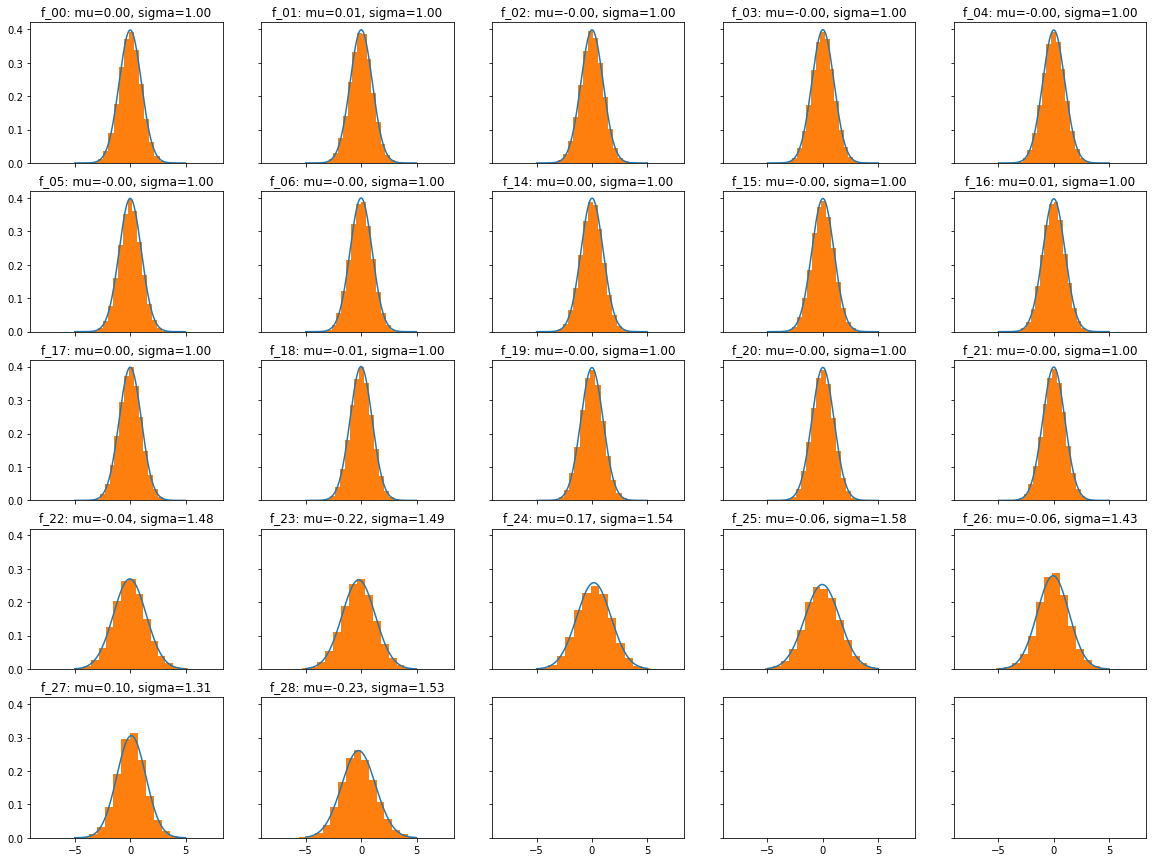

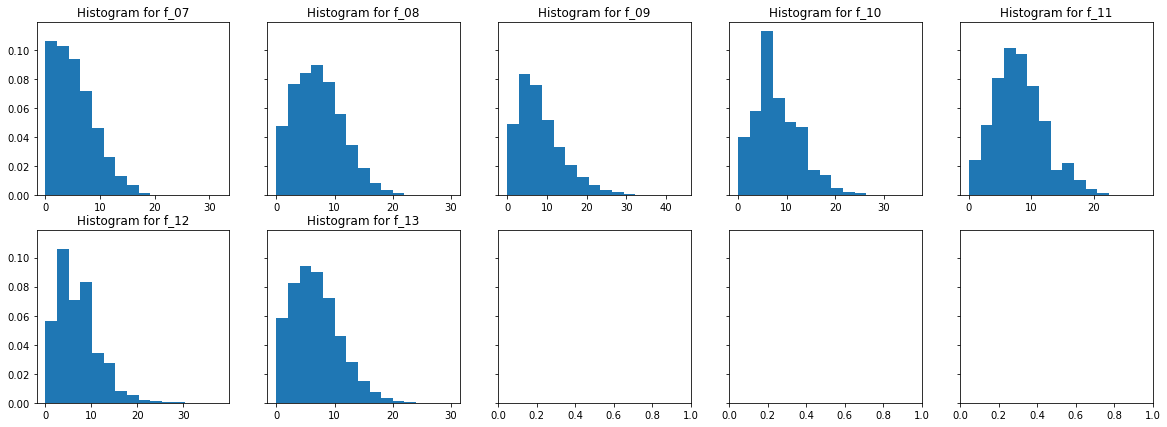

In [4]:
fig, axs = plt.subplots(5,5, figsize = (20,15), sharey=True, sharex=True)
fig2, axs2 = plt.subplots(2,5, figsize = (20,7), sharey=True)
i=0
j=0
ii=0
jj=0
x_axis = np.arange(-5, 5, 0.01)
normal_features = []
positive_features =[]
for feature in df.columns:
    if df[feature].min()<0:
        normal_features.append(feature)
        mean=df[feature].mean()
        sd=df[feature].std()
        axs[i,j].plot(x_axis, norm.pdf(x_axis,mean,sd))
        axs[i,j].hist(df[feature], bins = 20, density = True)
        axs[i,j].set_title(f"{feature}: mu={mean:.2f}, sigma={sd:.2f}")
        j+=1
        if j==5:
            j=0
            i+=1
    else:
        positive_features.append(feature)
        axs2[ii,jj].hist(df[feature], bins = 15, density = True)
        axs2[ii,jj].set_title(f"Histogram for {feature}")
        jj+=1
        if jj==5:
            jj=0
            ii+=1
plt.show()

# Standardize the data<a id='standardize'></a>

We apply `PowerTransformer` to center the data around the origin, rescale it to have standard deviation 1, and approximate the skewed data to a normal distribution.

As we see in the following plots, each feature now has a very good fit to N(0,1), except the features 07-13, which are a little off (these are the features that were skewed).

In [5]:
df_scaled = pd.DataFrame(PowerTransformer().fit_transform(df), columns = df.columns)

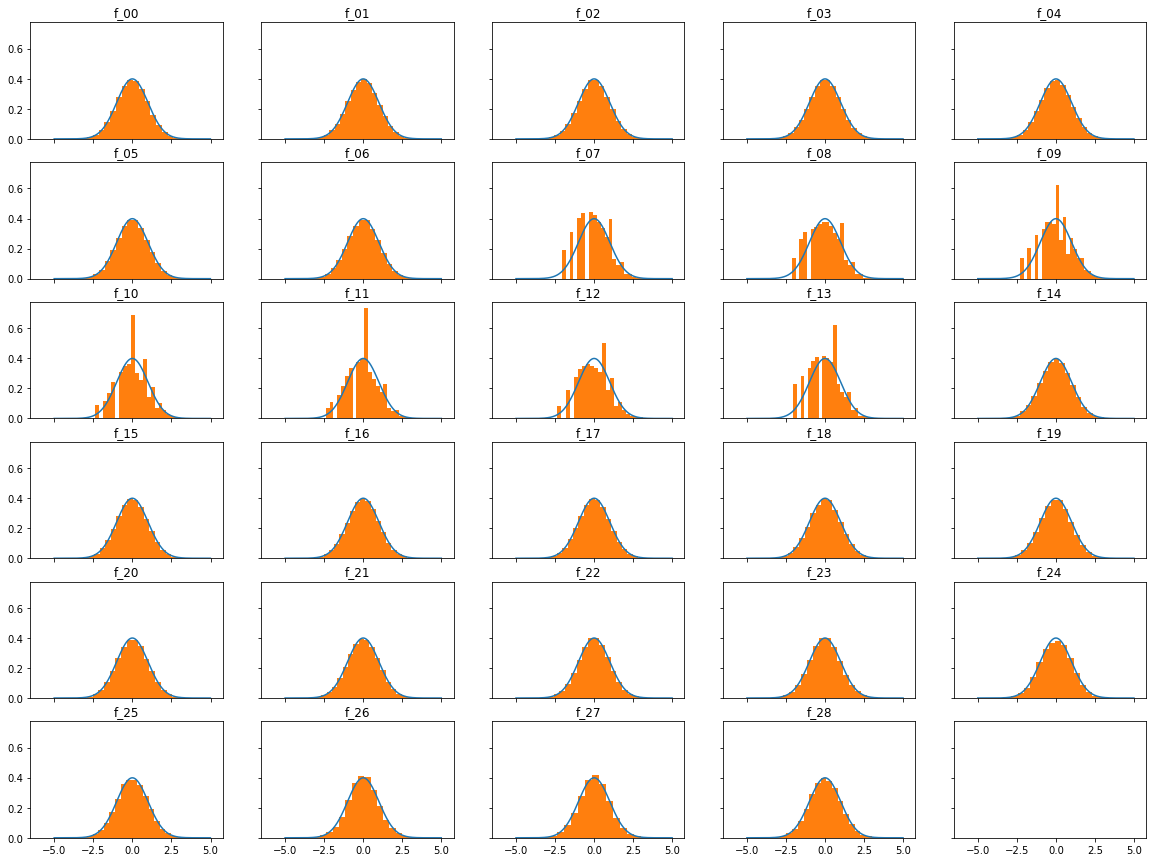

In [6]:
fig, axs = plt.subplots(6,5, figsize = (20,15), sharex=True, sharey=True)
i=0
j=0
x_axis = np.arange(-5,5,0.01)
for col in df_scaled:
    axs[i,j].plot(x_axis, norm.pdf(x_axis,0,1))
    axs[i,j].hist(df_scaled[col], bins = 25, density = True)
    axs[i,j].set_title(f"{col}")
    j+=1
    if j==5:
        j=0
        i+=1

# Feature selection<a id='featureselection'></a>

To determine which features are important, and which are not, we run a preliminary Gaussian Mixture model.

We then plot the means for each Gaussian in the mixture, recording the value of the mean for each feature. We can see that many of the features have means with little variance (00-06 and 14-21). These are dropped from the dataset below.

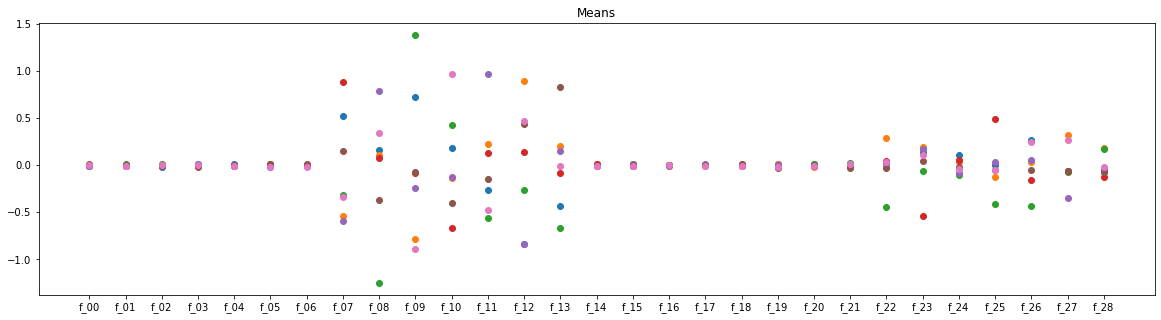

In [7]:
def get_gmm(n_comp, data):
    '''
    Fits a Gaussian Mixture model to the input data, with n_comp Gaussians in the mixture.
    '''
    gmm = GaussianMixture(n_components = n_comp)
    gmm.fit(data)
    return gmm

def plot_means(means):
    '''
    Plots the values of the means for each feature.
    '''
    fig, ax = plt.subplots(figsize=(20,5))
    for i in range(means.shape[0]):
        ax.scatter(df_scaled.columns, means[i])
        ax.set_title("Means")
    plt.show()
    
initial_gmm = get_gmm(7, df_scaled)
means = initial_gmm.means_    
plot_means(means)

We now drop those features where the corresponding coordinates of each mean in the mixture have small variance.

In [8]:
def drop_features(means):
    '''
    Drops the features where the means of the Gaussian Mixture have small variance.
    '''
    drop = []
    for i, col in enumerate(df_scaled.columns):
        std = np.std(means[:,i])
        if std < 0.05:
            drop.append(col)
    return df_scaled.drop(drop, axis=1)
    
df_reduced = drop_features(means)

# Outlier identification<a id='outliers'></a>

We remove outliers from our dataset before fitting the main model. We find outliers by fitting another Gaussian Mixture to our new reduced dataset, then using the probability density function (obtained via the method `.score_samples`) we filter our dataset to remove the data points that have low probabilities (i.e. low value of the pdf) of occuring.

As part of this step, we rescale the data again after outliers are removed.

In [9]:
outlier_gmm = get_gmm(7, df_reduced)
densities = outlier_gmm.score_samples(df_reduced) # evaluates log(pdf) at each sample point

threshold = np.percentile(densities,outlier_cut_off)  # density value of cut-off
df_reduced_no_outliers = pd.DataFrame(PowerTransformer().fit_transform(df_reduced[densities >= threshold]), columns = df_reduced.columns)
print("Preprocessing complete.")

Preprocessing complete.


# Variational Bayesian Gaussian Mixture<a id='vbgm'></a>

We are now ready to fit the VBGM model. We run it several times to get multiple predictions for each sample point.

The aim is to aggregate these predictions into one label for each point. Before we can do this, we have to ensure each cluster is given the same label by the algorithm.
Since the label each cluster is given is arbitrary each time the algorithm runs, we need to obtain a mapping to get consistent labelling.

We use the first random state to give us our target clusters and aim to relabel each other random state's clusters using these numbers. We do this by determining the intersection of each cluster and trying to map each cluster to the one with the largest intersection.

Sometimes the maps obtained are not one-to-one, and these random states have to be dropped.

In [10]:
def multi_vbgm(r,vbgm_state_count):
    '''
    Trains a user-determined number of Bayesian Gaussian Mixture Models, for different random states.
    '''
    df_reduced_with_probs = df_reduced.copy()
    converged_states =[]

    while len(converged_states) < vbgm_state_count:
        vbgm = BayesianGaussianMixture(n_components = 7,
                                       covariance_type = 'full',
                                       random_state = r, #Done: 42, scored 0.54374; 43: 0.58864; 44:0.52955
                                       max_iter = 200, # threw up ConvergenceWarning error with default (100) and 150
                                       n_init=2,
                                      )
        t0 = time()
        vbgm.fit(df_reduced_no_outliers)
        if vbgm.converged_ == True:
            converged_states.append(r)
            print(f"Random state {r}: it converged after {vbgm.n_iter_} steps and {time() - t0:.2f} seconds.")
            df_probs = pd.DataFrame(vbgm.predict_proba(df_reduced), columns = [f"Random_state-{r}_Cluster-{x}_proba" for x in range(7)])
            df_reduced_with_probs = pd.merge(df_reduced_with_probs, df_probs, left_index=True, right_index=True)
        else:
            print(f"Random state {r}: it did ----------not----------- converge  :-(")
        r+=1
    return df_reduced_with_probs, converged_states

In [11]:
def get_pair_cluster_map(r0,r1, cluster_dict):
    '''
    A map is obtained between cluster labels for two different models.
    
    Input: 
    integers r0 and r1 (random states to compare)
    dictionary with each value being a boolean pandas series identifying the observations in the corresponding cluster (as key).
    '''
    shared={}
    for x in range(7):
        shared[x]={}
        for y in range(7):
            shared[x][y] = (cluster_dict[r0][x] * cluster_dict[r1][y]).sum()

    # Determine the mappings: mappings[r1][x] is the state r1 cluster number corresponding to state r0 cluster number x
    this_map = {}
    for x in range(7):
        this_map[x] = max(shared[x], key = shared[x].get)
    return this_map

def get_clusters(df, states, column_name_before_sate,column_name_middle,column_name_after_cluster):
    '''
    Get the clusters for each random state
    '''
    clusters = {}
    for r in states:
        clusters[r] = {}
        for x in range(7):
            this_cluster = df[f"{column_name_before_sate}{r}{column_name_middle}{x}{column_name_after_cluster}"]  > 0.9
            clusters[r][x]=this_cluster
    return clusters

def get_cluster_maps(df_reduced_with_probs, target_states):
    '''
    Obtains the cluster maps and checks if they are one-to-one. If not, they are dropped.
    '''
    bad_states = []
    good_states = target_states
    
    # Get clusters
    clusters = get_clusters(df_reduced_with_probs, target_states, "Random_state-","_Cluster-","_proba")
    
    # Get mappings
    r0 = target_states[0]
    mappings = {}
    for r in target_states[1:]:
        mappings[r] = get_pair_cluster_map(r0,r,clusters)

    # Check one-to-one
        if len(set(mappings[r].values())) < 7:
            print(f"State {r} does not yield a one-to-one map. Dropping it.")
            bad_states.append(r)
            good_states.remove(r)

    print("Cluster mappings obtained.")   
#     if len(good_states)<4:
#         raise RuntimeError('Not enough random states with one-to-one maps.')
        
    return mappings, good_states, bad_states

def get_probs(df_reduced_with_probs, mappings, good_states):
    '''
    For each cluster, determine the average of the probabilities for each observation in the sample accross each random state.
    '''
    prob_cols = []
    r0 = good_states[0]
    for x in range(7):
        prob_cols.append(f"Overall_{x}_proba")
        df_reduced_with_probs[f"Overall_{x}_proba"] = df_reduced_with_probs[f"Random_state-{r0}_Cluster-{x}_proba"]
        for r in good_states[1:]:
            df_reduced_with_probs[f"Overall_{x}_proba"] += df_reduced_with_probs[f"Random_state-{r}_Cluster-{mappings[r][x]}_proba"]
        df_reduced_with_probs[f"Overall_{x}_proba"] = df_reduced_with_probs[f"Overall_{x}_proba"] / len(good_states)

    labels={'label':df_reduced_with_probs[prob_cols].idxmax(axis=1).apply(lambda string : re.search(r'\d+',string).group(0)),
            'prob':df_reduced_with_probs[prob_cols].max(axis=1)
           }
    return pd.DataFrame(labels)

# Classifier training<a id='clf'></a>

We extract the records with high probability of accuracy and then use these to train a classifier and obtain new predicted labels and probabilities.
This step is then repeated several times before reaching a final prediction.

In [12]:
def update_probs(r, data, prob_df, cut_off, KFold_train_index=[], return_all_probs=False):
    '''
    Trains a new VBGM classifier on those observations that are deemed very likely correct by the previously run model.
    If using KFold split then trains the data only on the training set, but assign labels and probs to all observations.
    
    Args:
        r  (int): random state to use in the model
        data (pandas dataframe): training data
        prob_df (pandas dataframe): probabilities obtained from a previously run model
        cut_off (flt): probability threshold to determine the observations to use in training new model
        KFold_train_index (list, optional): index values of training data if using KFold cross validation
        return_all_probs (bool): by default (False) it return the most likely cluster label and its probability. Change to True to return probabilities for each cluster label.
        
    Returns:
        pandas dataframe
    '''
    if len(KFold_train_index) > 0:
        new_filter = (prob_df.iloc[KFold_train_index]['prob'] > cut_off)
        X_train = data.iloc[KFold_train_index][new_filter]
        y_train = prob_df.iloc[KFold_train_index][new_filter]['label']
    else:
        new_filter = (prob_df['prob'] > cut_off)
        X_train = data[new_filter]
        y_train = prob_df[new_filter]['label']
    
    bgm_clf = BayesianGMMClassifier(n_components = 7,
                                covariance_type='full',
                                max_iter = 300,
                                n_init = 4,
                                random_state=r,
                               )
    
    bgm_clf.fit(X_train,y_train)
    new_probs = pd.DataFrame(bgm_clf.predict_proba(data), columns = range(7))
    new_labels = {'label': new_probs.idxmax(axis=1),
                  'prob': new_probs.max(axis=1)}
    if return_all_probs:
        return new_probs
    else:
        return pd.DataFrame(new_labels)

def iterate(data, base_probs, cut_off, steps, KFold = False, increase_cut_off = False, return_all_probs=False):
    '''
    Runs through the iteration process of fitting models.
    
    Input:
        data (pandas dataframe): training data
        base_probs (pandas dataframe): probabilities for each cluster, based on the vbgm model run earlier.
        cut_off (flt): probability threshold to determine the observations to use in training each new model.
        steps (int): number of times to iterate.
        KFold (bool): whether to split the data and set some aside to test accuracy.
        increase_cut_off (bool): whether to increase the probabilioty threshold after each step in the interation.
        return_all_probs (bool): by default (False) it return the most likely cluster label and its probability. Change to True to return probabilities for each cluster label.
    '''
    if KFold and return_all_probs:
        raise ValueError('Cannot do both KFold and return_all_probs.')
    i=0
    labels = base_probs
    if KFold:
        train_index, test_index = next(StratifiedKFold(n_splits = 3).split(labels['prob'],labels['label']))
        confident_labels_filter = (base_probs.iloc[test_index]['prob'] > cut_off)
        y_test = base_probs.iloc[test_index][confident_labels_filter]['label'].astype('int')
    else:
        train_index=[]
    while i< steps:
        t1 = time()
        if increase_cut_off:
            step_cut_off = cut_off + (i/steps)*(0.95 - cut_off)
        else:
            step_cut_off = cut_off
        if i<steps-1:
            labels = update_probs(i+50, data, labels, step_cut_off, train_index, return_all_probs=False)
        else:
            labels = update_probs(i+50, data, labels, step_cut_off, train_index, return_all_probs=return_all_probs)
        print(f"Step {i} took {time()-t1:.2f} seconds")
        if KFold:        
            y_pred = labels.iloc[test_index][confident_labels_filter]['label']
            score = accuracy_score(y_test, y_pred)
            print(f"Score after step {i} is {score:.3f}")
        i+=1
    print('iteration complete')
    if KFold:
        return labels, score
    else:
        return labels

In [13]:
def all_models(r,vbgm_state_count, training_prob_cut_off, iterate_steps, number_of_chunks=1, full_prob = False):
    '''
    Runs all the models, from the initial vbgm model to get initial cluster predictions to the iteration process updating the predictions.
    
    Args:
        r (int): choice or random_state
        vbgm_state_count (int): number of vbgm models to train to get base predictions
        training_prob_cut_off (flt): probability threshold to use when training iterated models
        iterate_steps (int): number of times to re-run the classification model
        number_of_chunks=1 (int): how many predictions to produce for each observation 
        full_prob = False (bool): whether to return predicted label and its probability only, or probabilities for each cluster
        
    Returns:
        Pandas dataframe if number_of_chunks = 1
        List of pandas dataframes if number_of_chunks > 1.
    '''
    t2=time()
    df_reduced_with_probs, converged_states = multi_vbgm(r,vbgm_state_count*number_of_chunks)
    output = []
    for i in range(number_of_chunks):
        print(f"-----------------\nChunk {i} beginning")
        mappings, good_states, bad_states = get_cluster_maps(df_reduced_with_probs, converged_states[i::number_of_chunks])
        if len(good_states) < 3:
            print("Insufficient one-to-one maps. Dropping this chunk.")
        else:
            df_labels = get_probs(df_reduced_with_probs, mappings, good_states)
            prob_df = iterate(df_reduced, df_labels, training_prob_cut_off, iterate_steps, KFold = False, increase_cut_off = False, return_all_probs = full_prob)
            output.append(prob_df)
    print(f'Probabilities obained in {time()-t2:.2f} seconds')
    if number_of_chunks == 1:
        return output[0]
    else:
        return output

In [14]:
final_probs = all_models(101,vbgm_state_count, training_prob_cut_off, iterate_steps)

Random state 101: it converged after 93 steps and 94.34 seconds.
Random state 102: it converged after 77 steps and 82.99 seconds.
Random state 103: it converged after 74 steps and 75.55 seconds.
Random state 104: it converged after 76 steps and 84.75 seconds.
Random state 105: it converged after 78 steps and 84.95 seconds.
Random state 106: it converged after 92 steps and 96.39 seconds.
Random state 107: it converged after 101 steps and 145.98 seconds.
Random state 108: it converged after 76 steps and 83.16 seconds.
Random state 109: it converged after 76 steps and 91.09 seconds.
Random state 110: it converged after 116 steps and 106.45 seconds.
Random state 111: it converged after 198 steps and 129.99 seconds.
Random state 112: it converged after 91 steps and 89.95 seconds.
Random state 113: it converged after 93 steps and 91.92 seconds.
Random state 114: it converged after 123 steps and 106.30 seconds.
Random state 115: it converged after 77 steps and 85.02 seconds.
Random state 116:

In [15]:
final_label = final_probs['label']

# Cluster visualization<a id='visualization'></a>

The last step before submitting the output is to quickly visualize the clusters. Using prinicipal component analysis we project to a 2-dimensional place and color the points by the assigned cluster.

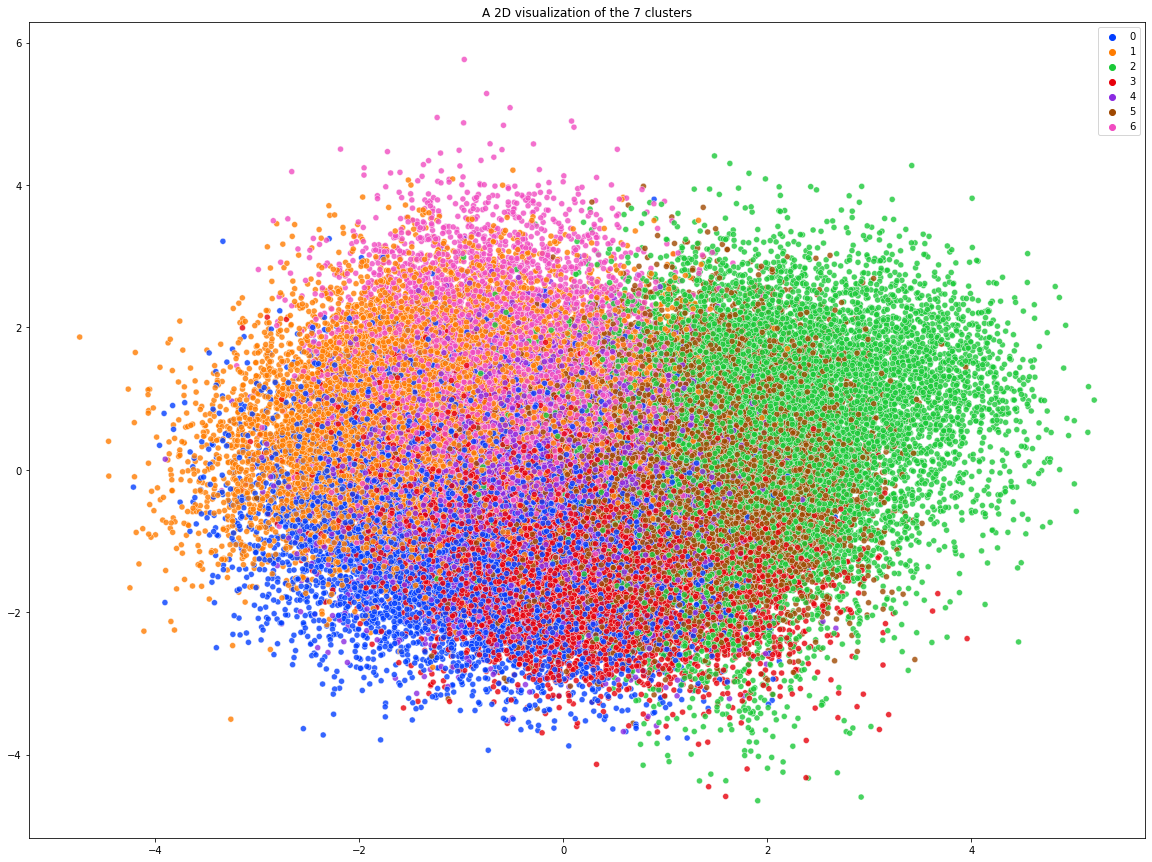

In [16]:
pca = PCA(n_components=2)
X_viz = pca.fit_transform(df_reduced)
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot(x=X_viz[:,0],y=X_viz[:,1], hue = final_label, ax=ax, palette = 'bright', alpha=0.8)
plt.title('A 2D visualization of the 7 clusters')
plt.legend()
plt.show()

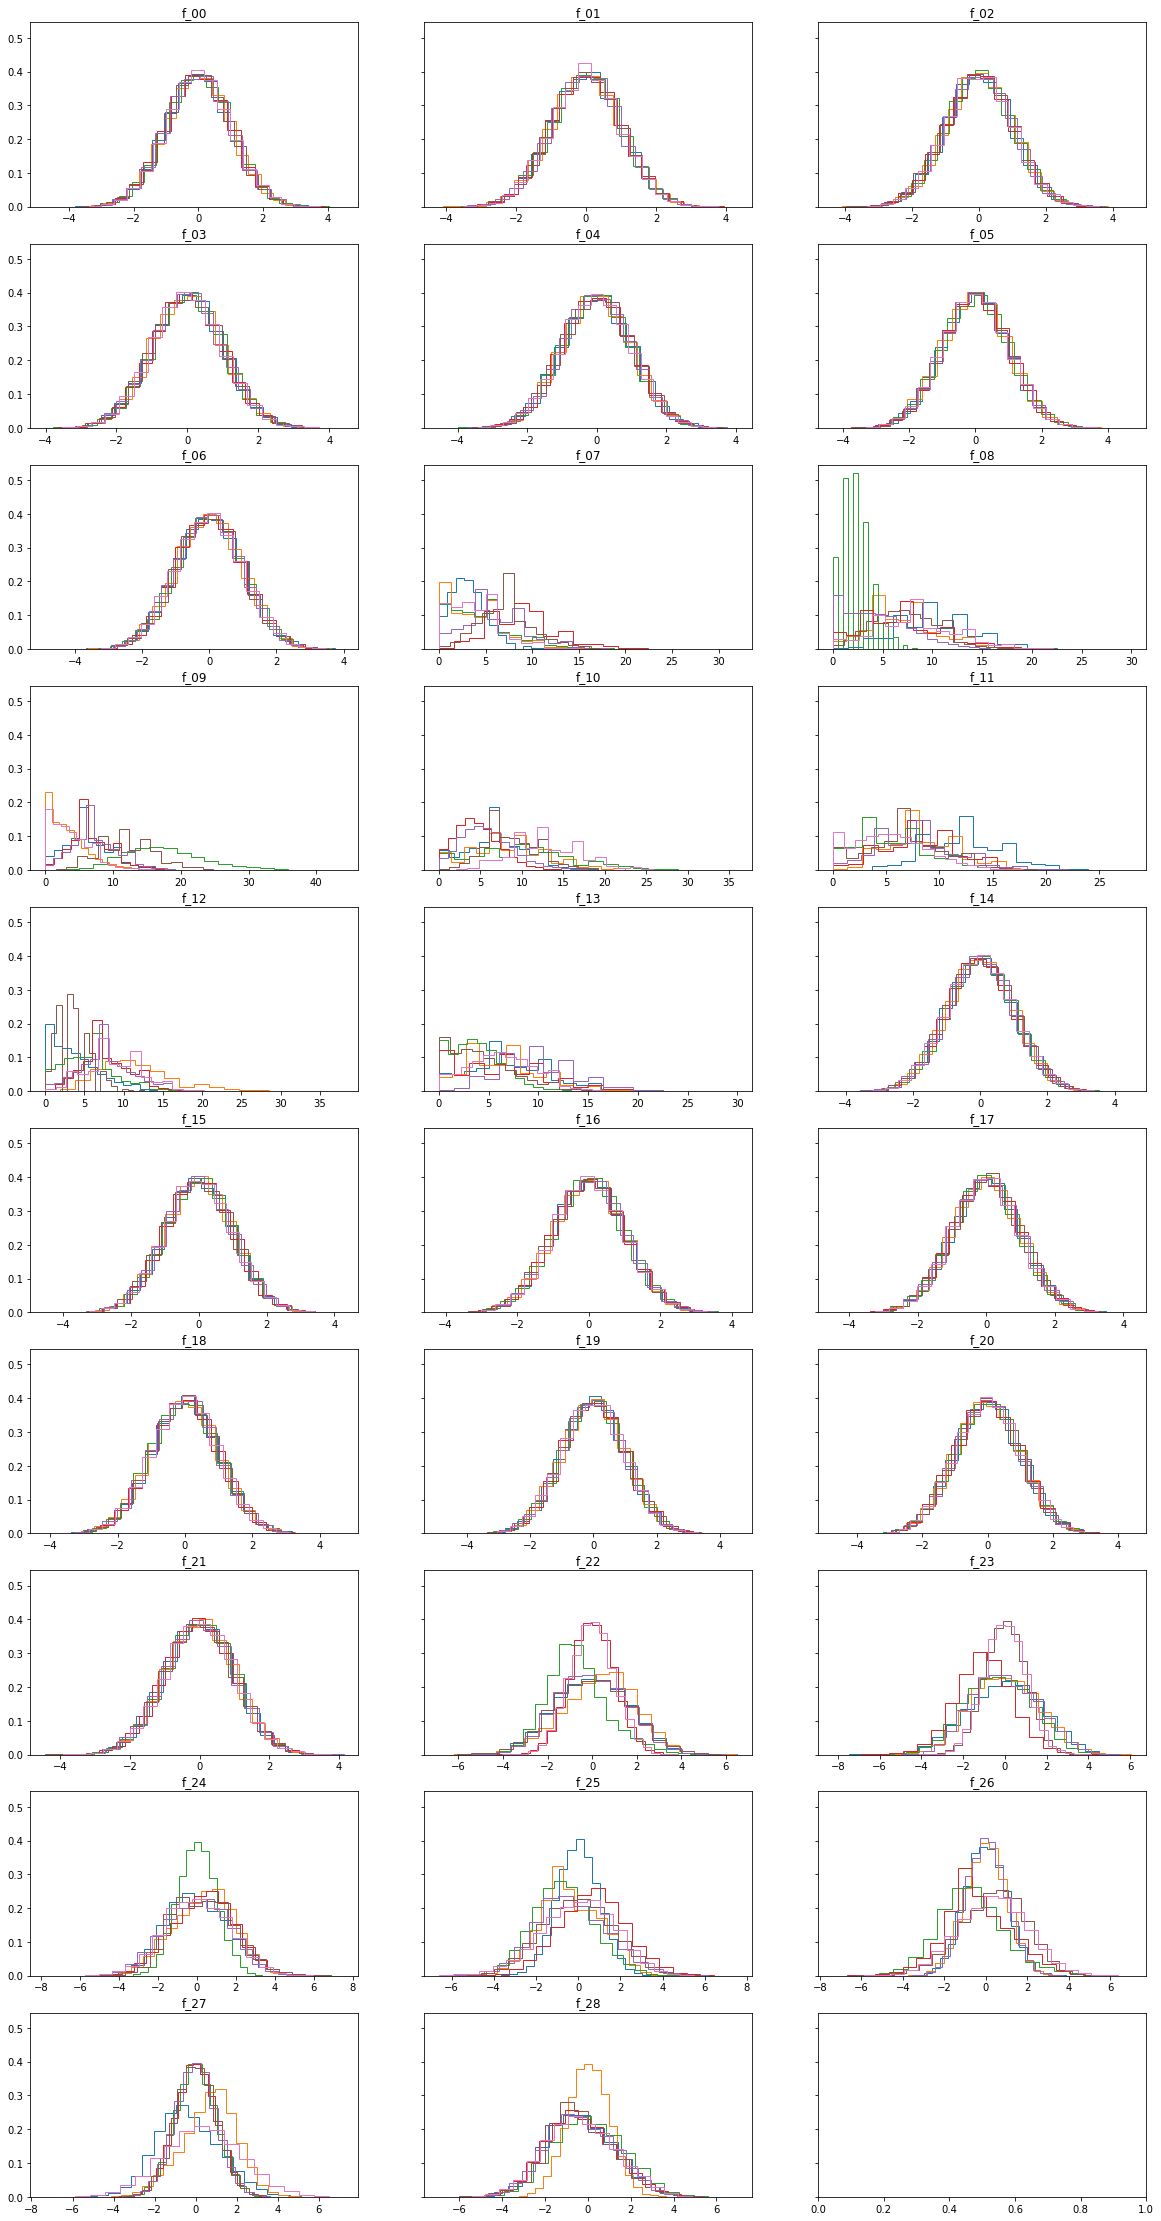

In [17]:
fig, axs = plt.subplots(10,3, figsize=(20,40), sharey=True)
for i, feature in enumerate(df.columns):
    for x in range(7):
        axs[int(i/3), i % 3].hist(x=df[feature][final_label == x], bins=20, histtype = 'step', density=True)
        axs[int(i/3), i % 3].set_title(f"{feature}")
plt.show()
    

# Submission<a id='submission'></a>

In [18]:
submission = pd.read_csv("sample_submission.csv")

submission["Predicted"] = final_label

submission.to_csv('submission.csv', index=False)